<a href="https://colab.research.google.com/github/eireford/ConwayLifeTensorFlow/blob/master/LTF_scipy_vs_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Life on TensorFlow

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time
import numpy as np
import scipy.signal
import timeit

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def default_config():
  return { 
      'grid_shape':  [1024,1024],
      # for reproducability reuse seed
      'seed': 1000,
      'preferred_size_inches': 16.02
   }

In [0]:
def random_uniform_grid(shape,seed):
  return tf.round(tf.random.uniform(shape=shape,dtype=tf.float32, seed=seed))

Use the default configuration and generate a grid of cells, randomly alive or dead.

In [0]:
config = default_config()
grid_shape, seed, preferred_size_inches, = config.values()
grid = random_uniform_grid(grid_shape,seed)

In [8]:
alive_total = tf.reduce_sum(grid)
ratio_alive = alive_total/(grid_shape[0]*grid_shape[1])
print("alive_total",int(alive_total))
print("alive_percent",float(ratio_alive*100))

alive_total 523811
alive_percent 49.95450973510742


In [0]:
livable_filter_tf = tf.constant([
                                [1,1,1],
                                [1,10,1],
                                [1,1,1]
                                ],dtype=tf.float32)

In [0]:
def convolve_for_density_tf(x):
  v = tf.reshape(livable_filter_tf, [3,3,1,1])
  a = tf.reshape(x,[1,grid_shape[0],grid_shape[1],1])
  denisty_map = tf.reshape(tf.nn.conv2d(a,v,[1,1,1,1],"SAME"),grid_shape)
  return denisty_map  

In [0]:
def convolve_for_density_sp(x):
  livable_filter_sp = [[1,1,1],[1,10,1],[1,1,1]]
  denisty_map = scipy.signal.convolve2d(x,livable_filter_sp,"same")
  return denisty_map  

In [0]:
def liveness_test_tf(x):
  return tf.cast(tf.where(((x == 3)|(x == 12)|(x == 13)),1,0),dtype=tf.float32)

In [0]:
def liveness_test_np(x):
  return (x == 3) | (x == 12) | (x == 13)

In [0]:
def population_report(x):
  alive_total = tf.reduce_sum(x)
  ratio_alive = alive_total/(grid_shape[0]*grid_shape[1])
  return "alive_total:" + str(int(alive_total)) + " alive_percent:" + str(float(ratio_alive*100))

In [0]:
def run_scipy(running_state,steps): 
  for i in range(steps):
    #if i%(steps//5) == 0:
      #print("step:",i,population_report(running_state))
    running_state = convolve_for_density_sp(running_state)
    running_state = liveness_test_np(running_state)
  return running_state

In [0]:
def run_tf(running_state,steps): 
  for i in range(steps):
    #if i%(steps//5) == 0:
      #print("step:",i,population_report(running_state))
    running_state = convolve_for_density_tf(running_state)
    running_state = liveness_test_tf(running_state)
  return running_state

In [0]:
def run_numpy(running_state,steps): 
  for i in range(steps):
    #if i%(steps//5) == 0:
      #print("step:",i,population_report(running_state))
    running_state = convolve_for_density_sp(running_state)
    running_state = liveness_test_np(running_state)
  return running_state

In [0]:
def tf_cpu(steps = 1000):
  with tf.device('/cpu:0'):
    result = run_tf(grid,steps)
  return result

In [0]:
def tf_gpu(steps = 1000):
  with tf.device('/gpu:0'):
    return run_tf(grid,steps)

In [0]:
def sp_cpu(steps = 1000):
  with tf.device('/cpu:0'):
    return run_scipy(grid,steps)

In [0]:
def sp_gpu(steps = 1000):
  with tf.device('/gpu:0'):
    return run_scipy(grid,steps)

In [22]:
print('tf_gpu')
tf_gpu_time = timeit.timeit('tf_gpu()', number=3, setup="from __main__ import tf_gpu")
print(tf_gpu_time)


tf_gpu
5.6097880939996685


In [23]:
print('sp_gpu')
sp_gpu_time = timeit.timeit('sp_gpu()', number=3, setup="from __main__ import sp_gpu")
print(sp_gpu_time)

sp_gpu
145.16466611200303


In [24]:
print('tf_cpu')
tf_cpu_time = timeit.timeit('tf_cpu()', number=3, setup="from __main__ import tf_cpu")
print(tf_cpu_time)

tf_cpu
286.64429663899864


In [25]:
print('sp_cpu')
sp_cpu_time = timeit.timeit('sp_cpu()', number=3, setup="from __main__ import sp_cpu")
print(sp_cpu_time)

sp_cpu
144.32153332800226


In [31]:
# %%script false --no-raise-error
 %time tf_gpu_result = tf_gpu(100)
 %time tf_cpu_result = tf_cpu(100)
 %time sp_gpu_result = sp_gpu(100)
 %time sp_cpu_result = sp_cpu(100)
 assert(np.array_equal(tf_gpu_result,tf_cpu_result))
 assert(np.array_equal(sp_gpu_result,sp_cpu_result))
 assert(np.array_equal(tf_gpu_result,sp_gpu_result))

CPU times: user 148 ms, sys: 11.1 ms, total: 159 ms
Wall time: 156 ms
CPU times: user 18.7 s, sys: 67.9 ms, total: 18.8 s
Wall time: 9.68 s
CPU times: user 4.86 s, sys: 12 ms, total: 4.87 s
Wall time: 4.88 s
CPU times: user 4.87 s, sys: 19 ms, total: 4.89 s
Wall time: 4.9 s


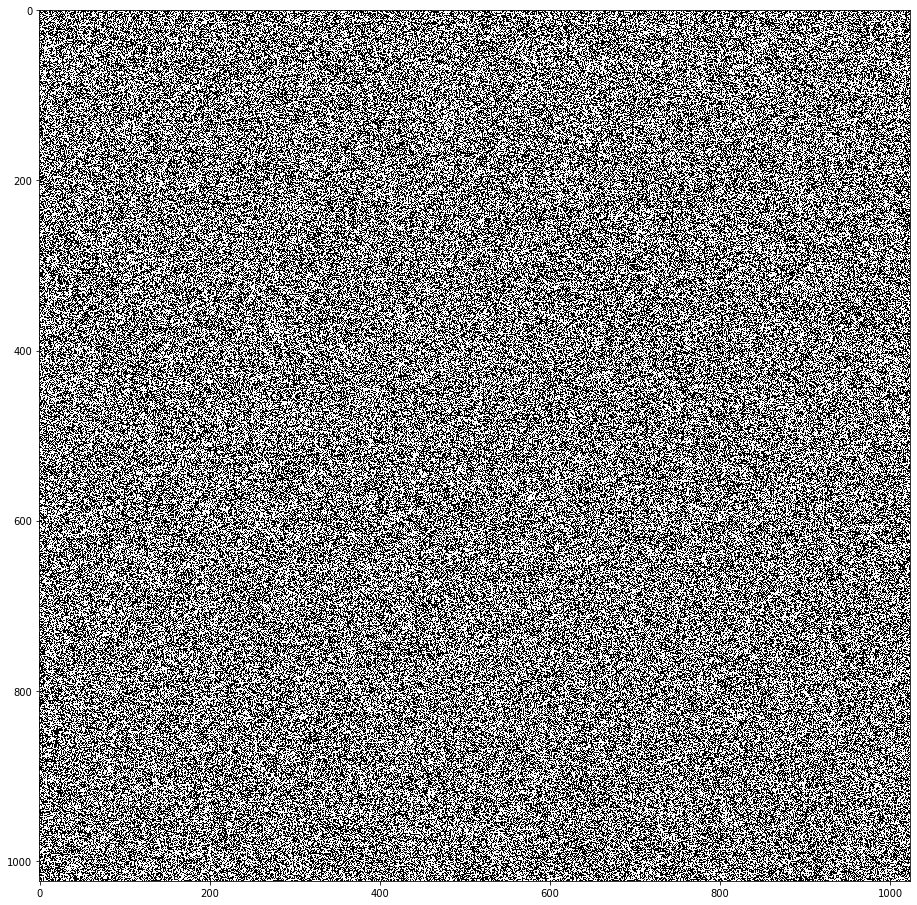

In [32]:
plt.gcf().set_size_inches(preferred_size_inches,preferred_size_inches)
figure_1 = plt.imshow(grid,cmap='Greys',origin='upper',interpolation='nearest')

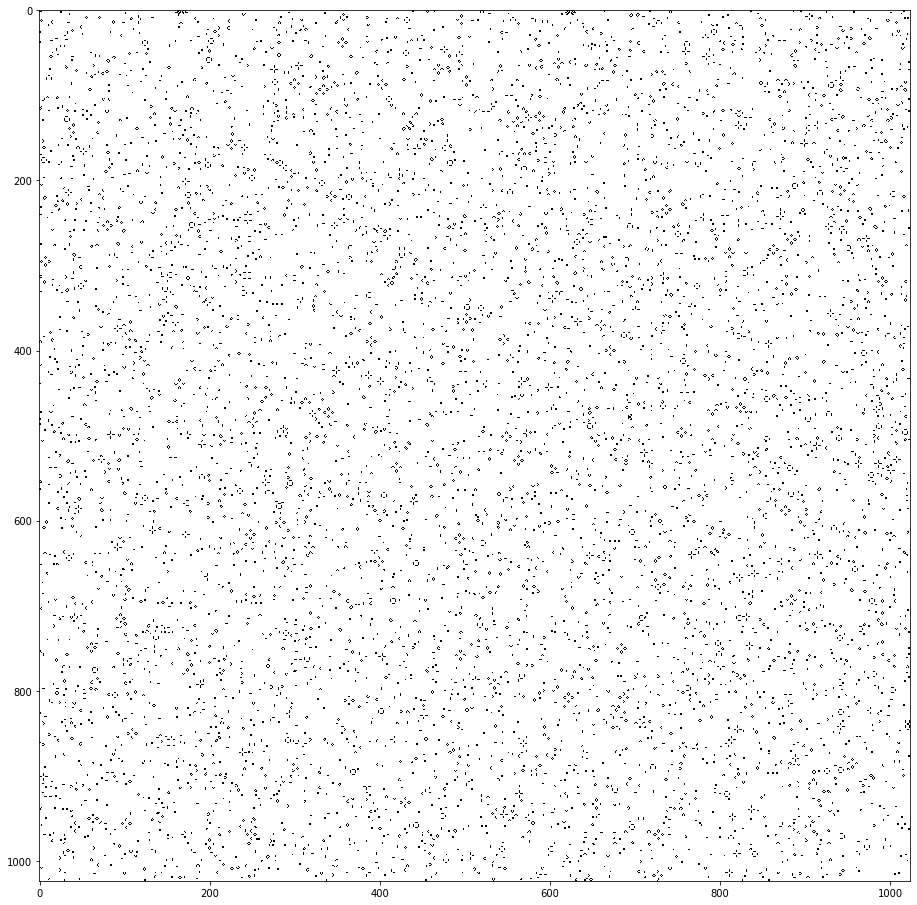

In [33]:
result = tf_gpu(10000)
plt.gcf().set_size_inches(preferred_size_inches,preferred_size_inches)
figure_3 = plt.imshow(result,cmap='Greys',origin='upper',interpolation='nearest') 

related works

https://laurentperrinet.github.io/sciblog/posts/2017-09-20-the-fastest-2d-convolution-in-the-world.html